# Carrefour Hackathon III
**Goal:** Predicting the category of a product. There exists a main category that is then split into sublevels.
The level we'll focus on in this project is the third one.

*Authors:* Vanessa Chahwan, Ashraf Ghiye, Karim Siala, Mohamed Ali Jebali, Rania Ferchichi 

---

This is the final and most important notebook. It contains our **final model and its evaluation.**
this notebook is complete in itself. We used the conclusions we drew from the first two notebooks. Which subset of images we'll use, and the resized files are already determined.

All the models' weights could be found in the models folder.

*NB: We provide a total of 3 notebooks; one for metadata exploration, one for creating a training set, and finally, one for the model and it's evaluation. Please refer to each notebook for the part you wish to see for this project.*

---

In [1]:
from google.cloud import bigquery
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

To keep this notebook as clean and simple as possible, some functions needed for data retrieval, cleaning, mapping and visualisation are in a seperate python script that we load here.

In [2]:
# loading all functions needed for cleaning, mapping ..
from util import *

# Data extraction and cleaning

In view of all our previous exploration and discussions, we will only consider the front views. That is, images with and id angle equal to **1, 11 or 31**. But we'll also consider only the first image of a certain product. Otherwise, we'd have **data leakage**: because the same product may have multiple images, when we shuffle and split our data, some may fall into the validation set. Our final accuracy will be inflated and misleading.

In [3]:
bq_client = bigquery.Client(location="EU", project="hackathon-2021-305208")

In [4]:
# In view of the previous data exploration,
# get the frontal views
df = querry_data(bq_client)
df.shape

(41315, 19)

In [5]:
# We've seen some products contain multiple primary links
# this will remove skewed rows and null values
# to construct a clean dataframe
data = clean_data(df)
data.shape

(40677, 3)

In [6]:
# we tried our models on images with different sizes
# returns the dataframe, filenames and labels for 
# a set of images with a certain size
images_file = '../images-299'

images = [join(images_file, f) \
          for f in listdir(images_file) \
          if isfile(join(images_file, f))]

data["filename"] = data["filename"].str.replace("gs://datacamp-images/images",
                                                images_file)

data = data[data.filename.isin(images) == True]
filenames = data['filename']
labels = data['label']
print(data.shape)
data.head()

(40583, 3)


,filename,label,level
0,../images-299/image_3307139936826_1_d7b35156.jpeg,28538,Herbes aromatiques et Epices
1,../images-299/image_3307139936826_31_d822034e.png,28538,Herbes aromatiques et Epices
2,../images-299/image_3770001023823_1_b2b13aa2.jpeg,1909,Pruneaux et Fruits séchés
3,../images-299/image_3770001023823_1_b66978c6.jpeg,1909,Pruneaux et Fruits séchés
4,../images-299/image_3770001023793_1_43dcccee.jpeg,28543,Fruits secs mélanges et graines


In [7]:
# contructs and returns a mapping between the nodeid3 ('label')
# and the level3 ('level')
# needed to retrieve the predictions for visual evaluation
level_map = pd.DataFrame(data['level'].groupby(by=data['label']).first())

# maps between the labels (nodeid) and the classes
labels_encode = encode_map(data, labels)
labels_decode = decode_map(data, labels)

# conrstructs ohe for each label
y_ohe = one_hot_encoding(data, labels, labels_encode)

# retrieve the label for every ohe of a class
y_reconstruct = one_hot_decoding(y_ohe, labels_decode)

level_map.head(3)

,level
label,
1847,Fromages
1848,Yaourts et Desserts
1854,Apéritifs


### Preparing test and validation sets

In [8]:
# Shuffle and split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

filenames_shuffled, y_ohe_shuffled  = shuffle(filenames, y_ohe) # pandas Series

# Used this line as our filename array is not a numpy array.
filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames_shuffled_numpy, y_ohe_shuffled, test_size=0.2, random_state=1)

print(X_train_filenames.shape)
print(X_val_filenames.shape)

(32466,)
(8117,)


### Adding external data

In [9]:
images = pd.read_csv("../added-images.csv")
print(images.shape)
images.head()

(13470, 3)


,barcode,filename,nodeid3
0,3770001023823,image_1.jpg,1909
1,3770001023793,image_2.jpg,28543
2,3560070538805,image_3.jpg,1912
3,3700146205532,image_4.jpg,28543
4,3329480018815,image_5.jpg,28543


In [10]:
# we clean this the way we cleaned our original data

to_keep = ['filename', 'nodeid3']

data_ext = images.drop_duplicates(['barcode'], keep='first')[to_keep]
data_ext = data_ext.dropna()
data_ext = data_ext.rename(columns={"nodeid3":"label"})
data_ext["filename"] = "../added-images-299/" + data_ext["filename"]

In [11]:
print(data_ext.shape)
data_ext.head()

(13434, 2)


,filename,label
0,../added-images-299/image_1.jpg,1909
1,../added-images-299/image_2.jpg,28543
2,../added-images-299/image_3.jpg,1912
3,../added-images-299/image_4.jpg,28543
4,../added-images-299/image_5.jpg,28543


In [12]:
filenames_ext = data_ext['filename']
labels_ext = data_ext['label']
print(labels_ext.nunique())

376


In [13]:
# contructs and returns a mapping between the nodeid3 ('label')
# and the level3 ('level')
# needed to retrieve the predictions for visual evaluation
# maps between the labels (nodeid) and the classes
labels_encode_ext = encode_map(data_ext, labels_ext)
labels_decode_ext = decode_map(data_ext, labels_ext)

# conrstructs ohe for each label
y_ohe_ext = one_hot_encoding(data_ext, labels_ext, labels_encode_ext)

# retrieve the label for every ohe of a class
y_reconstruct_ext = one_hot_decoding(y_ohe_ext, labels_decode_ext)

In [14]:
from sklearn.utils import shuffle

filenames_shuffled_ext, y_ohe_shuffled_ext  = shuffle(filenames_ext, y_ohe_ext)
from sklearn.model_selection import train_test_split

# Used this line as our filename array is not a numpy array.
filenames_shuffled_numpy_ext = np.array(filenames_shuffled_ext)

X_train_filenames_ext, X_val_filenames_ext, y_train_ext, y_val_ext = train_test_split(
    filenames_shuffled_numpy_ext, y_ohe_shuffled_ext, test_size=0.2, random_state=1)

print(X_train_filenames_ext.shape)
print(X_val_filenames_ext.shape)

(10747,)
(2687,)


## Prepare the final sets and generator

In [15]:
X_train = np.concatenate((X_train_filenames, X_train_filenames_ext))
X_val = np.concatenate((X_val_filenames, X_val_filenames_ext))

print(X_train.shape, X_val.shape)

(43213,) (10804,)


Note that the external data only covers **376** classes. Before we concatenate the external and original data, we need to padd the one hot encoding of the external data till it has the same shape of the original.

In [16]:
# train
tmp = np.zeros((y_train_ext.shape[0], y_train.shape[1]))
tmp[:y_train_ext.shape[0], :y_train_ext.shape[1]] = y_train_ext

Y_train = np.concatenate((y_train, tmp))
Y_train.shape

(43213, 427)

In [17]:
# validation
tmp = np.zeros((y_val_ext.shape[0], y_val.shape[1]))
tmp[:y_val_ext.shape[0], :y_val_ext.shape[1]] = y_val_ext

Y_val = np.concatenate((y_val, tmp))
Y_val.shape

(10804, 427)

In [18]:
# Shuffle all data

X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val, Y_val)

In [19]:
import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_filenames, labels=None, batch_size=32, training=True):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.training = training
    
    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx+1) * self.batch_size]
        X = np.array([cv2.imread(str(file_name)) for file_name in batch_x])
        X = preprocess_input(X)
        if self.training:
            batch_y = self.labels[idx * self.batch_size:(idx+1) * self.batch_size]
            return X, np.array(batch_y)
        else:
            return X

Using TensorFlow backend.


In [21]:
batch_size = 32

training_batch_generator = DataGenerator(X_train, Y_train, batch_size)
validation_batch_generator = DataGenerator(X_val, Y_val, batch_size)

In [22]:
import tensorflow as tf
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

from tensorflow.python.keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Final Model

In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from keras.models import Model, Sequential


xception = Xception(weights='imagenet', include_top=False,input_shape=(299,299,3))
freeze_stop = 15

for layer in xception.layers:
    layer.trainable = False
        
for layer in xception.layers[-freeze_stop:]:
    layer.trainable = True

In [ ]:
from keras.optimizers import Adam
from keras.regularizers import l2

nclasses = Y_train.shape[1]
opt = Adam(learning_rate=1e-4)

model = Sequential()
model.add(xception)
model.add(Flatten())
model.add(Dense(128,
                kernel_regularizer=l2(0.01), 
                bias_regularizer=l2(0.01) , 
                activation='relu'))
model.add(Dense(nclasses,activation='softmax'))

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# callbacks for our model, early stopping and saving the best models weights
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
mc = ModelCheckpoint('models/mld_ndrop.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
steps_per_epoch = int(X_train.shape[0] // batch_size)
val_steps = int(X_val.shape[0] // batch_size)

history = model.fit(
              training_batch_generator,
              steps_per_epoch = steps_per_epoch,
              epochs = 20,
              verbose = 1,
              validation_data = validation_batch_generator,
              validation_steps = val_steps,
              callbacks=[es, mc]
             )

In [ ]:
figure = plt.figure(figsize=(8,5))

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model performance")
plt.ylabel("performance")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [5]:
!nvidia-smi

Mon Mar 22 07:09:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    21W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Evaluation

### Evaluation on the validation set

In [20]:
from keras.models import load_model
from util import *

# loading the model to evaluate
model = load_model('models/last_last_part3.hdf5') # this is our bets model

In [21]:
# maps between the labels (nodeid) and the classes
labels_encode = encode_map(data, labels)
labels_decode = decode_map(data, labels)

# conrstructs ohe for each label
y_ohe = one_hot_encoding(data, labels, labels_encode)

# retrieve the label for every ohe of a class
y_reconstruct = one_hot_decoding(y_ohe, labels_decode)

In [ ]:
y_val_label = one_hot_decoding(Y_val, labels_decode)
y_vl = [str(x) for x in y_val_label]
val_levels = level_map['level'].loc[y_vl].tolist()

In [ ]:
show_predictions_for(None, y_pred=val_levels, start=150, filenames=X_val)

## Evaluating the test set

In [22]:
test_images = [join("../test-images-299/", f) for f in listdir("../test-images-299/") if isfile(join("../test-images-299/", f))]

In [23]:
testing_batch_generator = DataGenerator(test_images, batch_size=32, training=False)

In [24]:
# classes
y_pred = np.argmax(model.predict(testing_batch_generator), axis=1)

# nodeids
y_label = [labels_decode[y] for y in y_pred]

# level map
pred_levels = level_map['level'].loc[y_label].tolist()

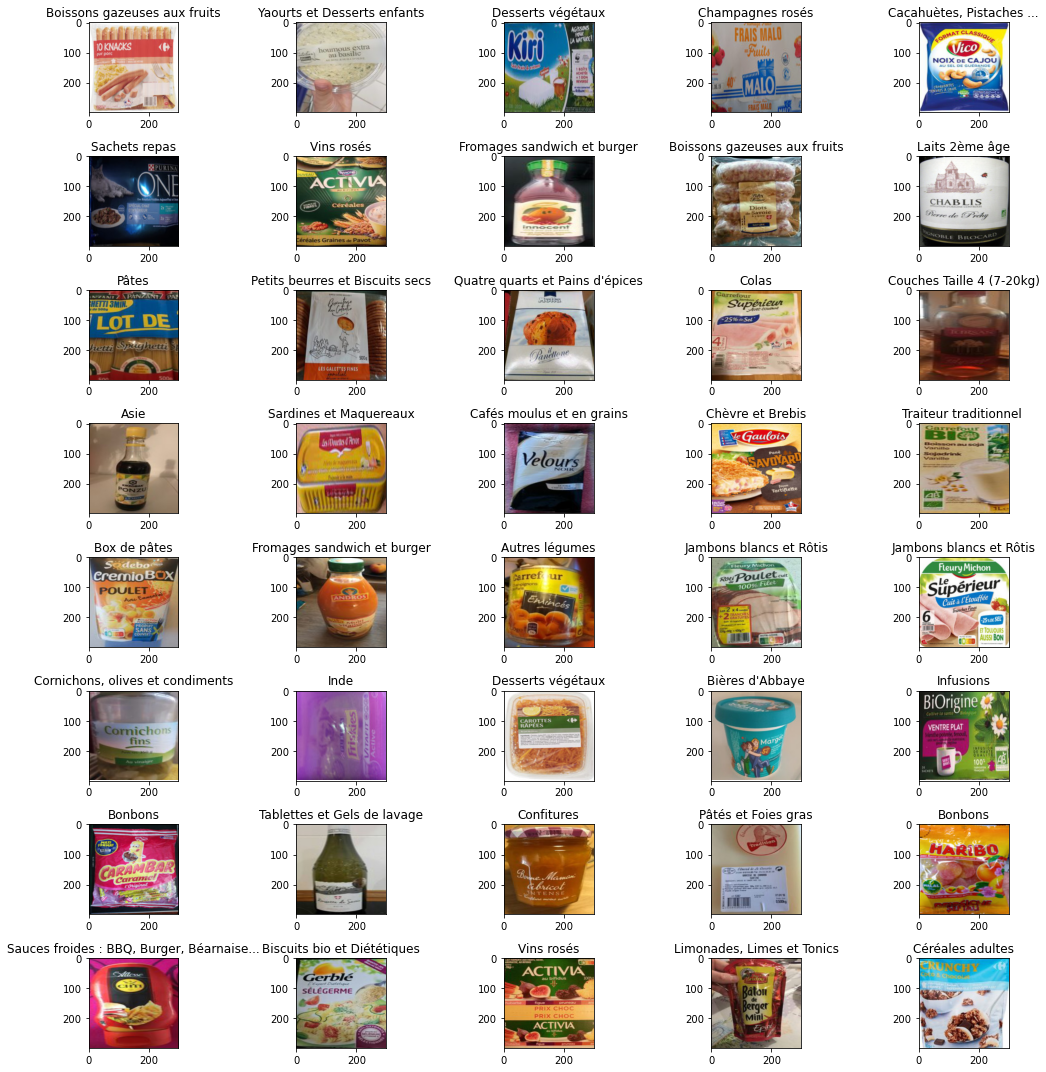

In [26]:
show_predictions_for(None, y_pred=pred_levels, start=200, filenames=test_images)

## Final submission

In [114]:
test_filenames = test_files.str.replace("../test-images-299/", '')
test_filenames

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0         f998fd99_ccc45eda5959_front_fr.4.200.jpg
1        db5400e7_224b31b74035_front_fr.11.200.jpg
2         c819c8f2_88a9d894b485_front_fr.5.200.jpg
3         283061d2_6c256412fd11_front_fr.4.200.jpg
4        ae1bfd5a_c5e3199adacf_front_fr.15.200.jpg
                           ...                    
13162     8a05e88b_5e40133a8653_front_fr.4.200.jpg
13163     c479df8e_572bb439980c_front_fr.6.200.jpg
13164    764f3d27_190455a44b23_front_fr.12.200.jpg
13165    569feb6d_03c5f5e2384c_front_fr.14.200.jpg
13166    5e34d3fc_97434e5aa4ea_front_fr.29.200.jpg
Name: image_filenames, Length: 13167, dtype: object

In [116]:
predictions = pd.Series(pred_levels, name='predictions')
test_files = pd.Series(test_filenames, name='image_filenames')

In [126]:
submission = pd.concat([test_files, predictions], axis=1)
submission.head()

In [120]:
bq_client = bigquery.Client(location="EU", project="hackathon-2021-305208")

In [128]:
# some variables
PROJECT_ID = 'hackathon-2021-305208'
dataset_id = 'group5'
table_id = 'predictions_test_images'
# filename = 'predictions_test_images.csv' # in case loading form csv files

In [129]:
# creates the table, this is already done, keep comment
bq_client.create_table(f"{PROJECT_ID}.{dataset_id}.{table_id}")

Table(TableReference(DatasetReference('hackathon-2021-305208', 'group5'), 'predictions_test_images'))

In [130]:
# tell the client everything it needs to know to upload our csv
dataset_ref = bq_client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
job_config = bigquery.LoadJobConfig()
job_config.source_format = bigquery.SourceFormat.CSV
job_config.autodetect = True

In [131]:
# load the dataframe into bigquery
with open(filename, "rb") as source_file:
    job = bq_client.load_table_from_dataframe(submission, 
                                              table_ref, 
                                              job_config=job_config)

job.result()  # Waits for table load to complete.

# looks like everything worked :)
print("Loaded {} rows into {}:{}.".format(job.output_rows, dataset_id, table_id))

Loaded 13167 rows into group5:predictions_test_images.
